In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Nacitanie iris datasetu
# X - features (data)
# y - triedy (setosa, versicolor, virginica)
iris = load_iris()
X = iris.data
y = iris.target

In [28]:
print("Dataset shape:", X.shape)
print("Labels:", set(y))
print("Classes:", iris['target_names'])

iris_df = pd.DataFrame(X, columns=iris.feature_names)
iris_df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
iris_df.head()

Dataset shape: (150, 4)
Labels: {0, 1, 2}
Classes: ['setosa' 'versicolor' 'virginica']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
# Rozdelenie datasetu na trenovaciu a testovaciu cast (test_size = 0.3 znamena 30% testovacia cast)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

In [5]:
# Vizualizacia datasetu pomocou bodoveho grafu
def create_scatter_plot(X, y, features, title):
    # Set up the figure and axis
    plt.figure(figsize=(12, 10))
    plt.suptitle(title, fontsize=16)

    # Create a scatter plot for each pair of features
    plot_number = 1
    for i in range(len(features)):
        for j in range(len(features)):
            if i < j:
                plt.subplot(2, 3, plot_number)
                for target in np.unique(y):
                    subset = X[y == target]
                    plt.scatter(subset[:, i], subset[:, j], label=iris.target_names[target])
                plt.xlabel(features[i])
                plt.ylabel(features[j])
                plt.legend()
                plot_number += 1

    plt.show()

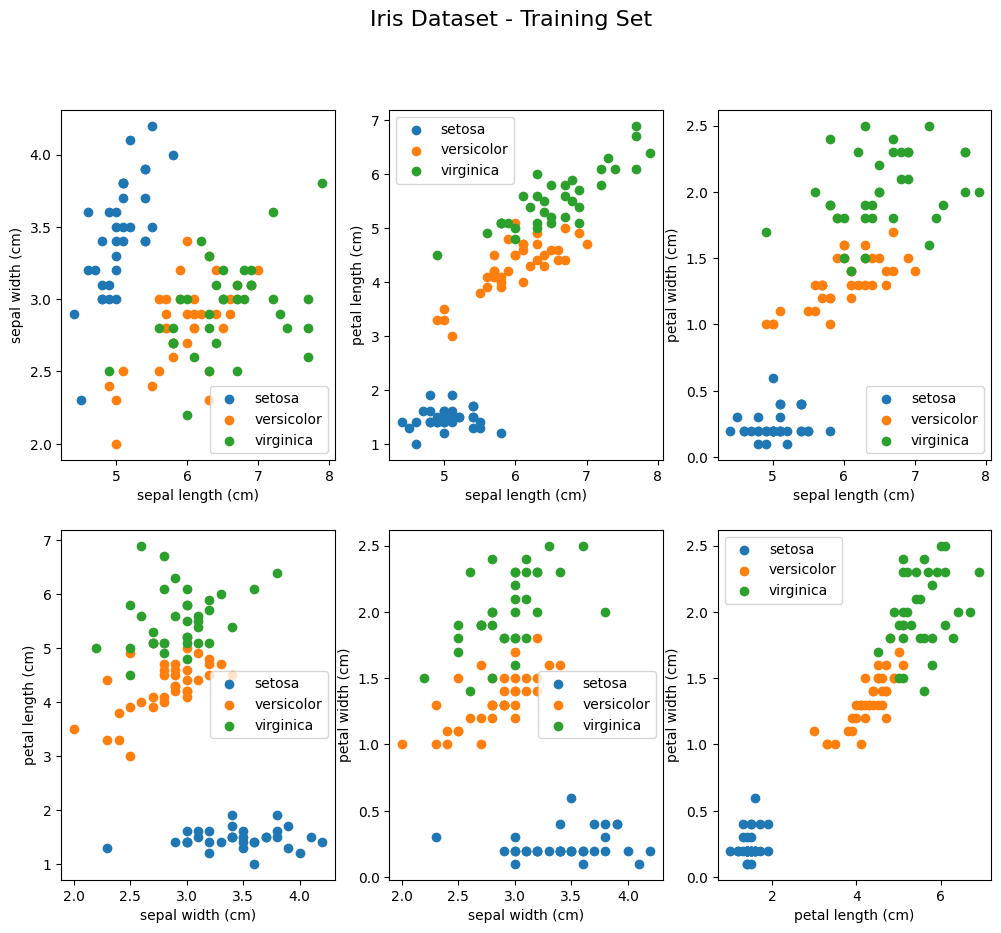

In [6]:
# Vizualizacia trenovacieho setu
create_scatter_plot(X_train, y_train, iris.feature_names, 'Iris Dataset - Training Set')

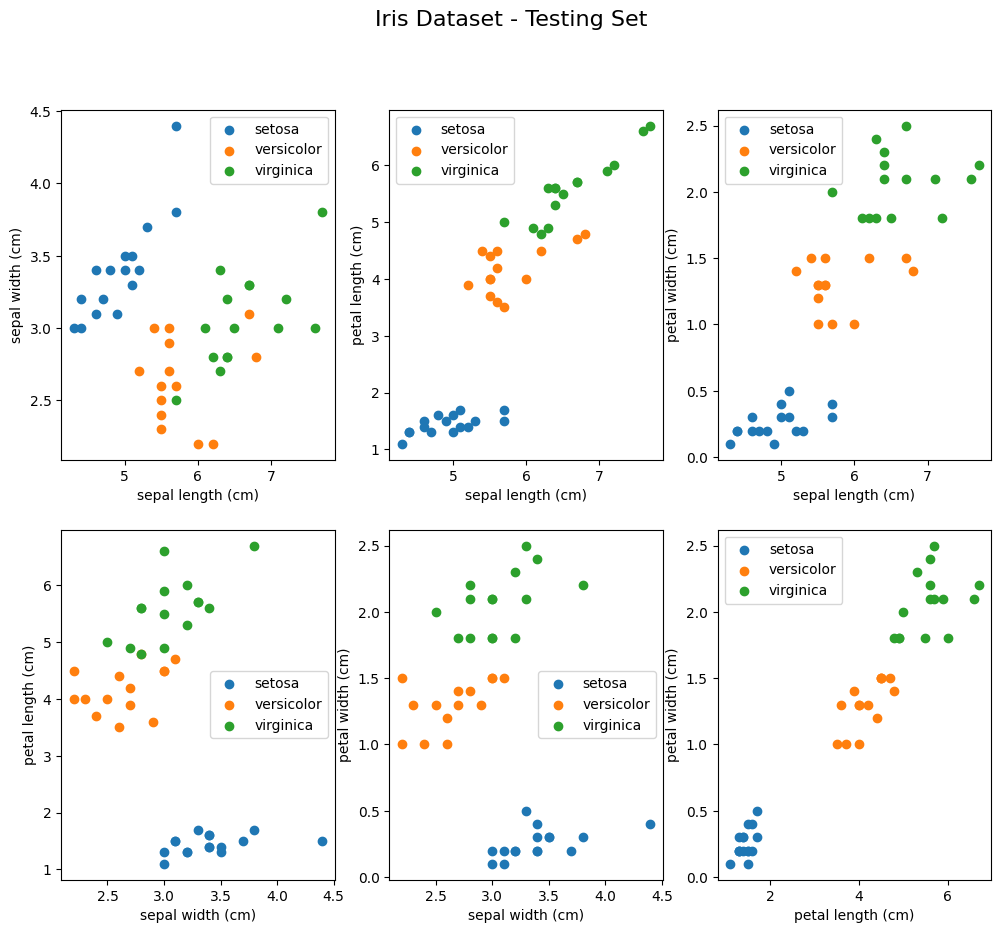

In [7]:
# Vizualizacia testovacieho setu
create_scatter_plot(X_test, y_test, iris.feature_names, 'Iris Dataset - Testing Set')

In [8]:
# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# Konvertovanie na tensory
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [10]:
# Vytvorenie dataset objektov
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Vytvorenie loaderov pre loadovanie dat pocas treningu
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [11]:
# MLP Model: Likely to perform well given the simplicity and small size of the Iris dataset. MLPs are generally good for tabular data.
# CNN Model: Might be less effective since the Iris dataset is not image data, and CNNs are primarily designed for spatial data. However, with proper adaptation, it can still perform reasonably well.
# RNN Model: RNNs are designed for sequential data, which the Iris dataset is not. Its performance might be less intuitive and could vary depending on how the input data is structured and fed into the model.

In [12]:
# Definovanie MLP Modelu
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        # 4 input features, 8 neuronov
        self.fc1 = nn.Linear(4, 10)
        self.fc2 = nn.Linear(10, 10)
        # output layer
        self.fc3 = nn.Linear(10, 3)

    # Metoda pre predikciu
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
# Definovanie CNN Modelu
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, 3)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(16, 3)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [14]:
# Definovanie RNN Modelu
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=8, batch_first=True)
        self.fc = nn.Linear(8, 3)

    def forward(self, x):
        x = x.unsqueeze(2)  # Add a feature dimension
        x, _ = self.rnn(x)
        x = x[:, -1, :]  # Take the last time step
        x = self.fc(x)
        return x

In [15]:
# Trenovaci loop, pouziva back propagation
def train(model, criterion, optimizer, epoch_number):
    for epoch in range(epoch_number):
        for data in train_loader:
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

In [16]:
# Funkcia pre vyhodnotenie modelu na testovacich datach
def evaluate_model(model, data_loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [17]:
mlp_model = MLPModel()
cnn_model = CNNModel()
rnn_model = RNNModel()

# Definovanie loss funkcie a optimalizatorov
criterion = nn.CrossEntropyLoss()

mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Trenovacie modely
print("MLP")
train(mlp_model, criterion, mlp_optimizer, 90)
print("CNN")
train(cnn_model, criterion, cnn_optimizer, 90)
print("RNN")
train(rnn_model, criterion, rnn_optimizer, 90)

# Evaluacia modelov
mlp_accuracy = evaluate_model(mlp_model, test_loader)
cnn_accuracy = evaluate_model(cnn_model, test_loader)
rnn_accuracy = evaluate_model(rnn_model, test_loader)

MLP
Epoch 1, Loss: 1.1077685356140137
Epoch 2, Loss: 1.1075223684310913
Epoch 3, Loss: 1.0971390008926392
Epoch 4, Loss: 1.0657093524932861
Epoch 5, Loss: 1.0363072156906128
Epoch 6, Loss: 1.078873634338379
Epoch 7, Loss: 0.9957442879676819
Epoch 8, Loss: 1.0043305158615112
Epoch 9, Loss: 1.0350446701049805
Epoch 10, Loss: 1.0597409009933472
Epoch 11, Loss: 0.983073353767395
Epoch 12, Loss: 1.011528491973877
Epoch 13, Loss: 0.976097822189331
Epoch 14, Loss: 0.8965789079666138
Epoch 15, Loss: 0.9290363788604736
Epoch 16, Loss: 0.8759713172912598
Epoch 17, Loss: 0.8820871710777283
Epoch 18, Loss: 0.9635952711105347
Epoch 19, Loss: 0.7210580110549927
Epoch 20, Loss: 0.7038989067077637
Epoch 21, Loss: 0.7864477634429932
Epoch 22, Loss: 0.7741749286651611
Epoch 23, Loss: 0.6047635078430176
Epoch 24, Loss: 0.6139786243438721
Epoch 25, Loss: 0.673026978969574
Epoch 26, Loss: 0.4026855230331421
Epoch 27, Loss: 0.6745368242263794
Epoch 28, Loss: 0.7182533740997314
Epoch 29, Loss: 0.684356391429

In [18]:
def classify_samples(model, tensor):
    # Pass the samples through the model
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        predictions = model(new_samples_tensor)
        _, predicted_classes = torch.max(predictions, 1)
    
    # Print the class names
    for i, index in enumerate(predicted_classes):
        print(f"Sample {i+1}: {iris['target_names'][index]}")

In [19]:
print(f'MLP Accuracy: {mlp_accuracy}%')
print(f'CNN Accuracy: {cnn_accuracy}%')
print(f'RNN Accuracy: {rnn_accuracy}%')
print("================================")

# Testuje nové vzorky na MLP modeli, transformuje ich, konvertuje na tenzory, predpovedá triedy a vypisuje názvy predpovedaných tried

new_samples = np.array([
    [5.1, 3.5, 1.4, 0.2],
    [6.7, 3.0, 5.2, 2.3],
    [5.9, 3.0, 4.2, 1.5],
    [6.1, 2.9, 4.7, 1.4],
    [4.6, 3.4, 1.4, 0.3]
])

# Scale the samples
new_samples_scaled = scaler.transform(new_samples)

# Konvertovanie na tensor
new_samples_tensor = torch.tensor(new_samples_scaled, dtype=torch.float32)

print("MLP")
classify_samples(mlp_model, new_samples_tensor)
print("CNN")
classify_samples(cnn_model, new_samples_tensor)
print("RNN")
classify_samples(rnn_model, new_samples_tensor)

MLP Accuracy: 100.0%
CNN Accuracy: 100.0%
RNN Accuracy: 93.33333333333333%
MLP
Sample 1: setosa
Sample 2: virginica
Sample 3: versicolor
Sample 4: versicolor
Sample 5: setosa
CNN
Sample 1: setosa
Sample 2: virginica
Sample 3: versicolor
Sample 4: versicolor
Sample 5: setosa
RNN
Sample 1: setosa
Sample 2: virginica
Sample 3: versicolor
Sample 4: versicolor
Sample 5: setosa
